# Twitter Sentiment Analysis Project

## Overview
The goal of this project is to build a machine learning model that analyzes tweets and predicts tweet sentiments (positive or negative).

## Business Problem
Apple and Google both hired a data scientist to build a machine learning model to analyze shared tweets about their products during the 2011 SXSW Tech Conference. The algorithm will predict whether the sentiment of the tweet is positive or negative. So The model will predict whether a customer is satisfied or not with both apple and google products from the tweet content, so both companies can improve the customer’s experience. 

## Data Understanding
The dataset is from the data.world website. The information will give us an insight into the customers' satisfaction from the tweets about the apple or google products.
The dataset consists of 9,093 rows and 3 columns with different features
* The tweet about the product during the Tech conference
* The Product type that was tweeted about.
* The type of emotion, which was classified as positive, negative, no emotion, or can’t tell.


In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# nltk 
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

#wordcloud
from wordcloud import WordCloud, STOPWORDS

import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score,roc_auc_score,precision_score


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

## Data Gathering

In [2]:
# read in the data
df =pd.read_csv("data/judge-1377884607_tweet_product_company.csv",encoding="'ISO-8859-1'")
df.head()
# encoding type from: https://stackoverflow.com/questions/21504319/python-3-csv-file-giving-unicodedecodeerror-utf-8-codec-cant-decode-byte-err

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# rename the columns 
df = df.rename(columns={"tweet_text":"tweet","emotion_in_tweet_is_directed_at":"product",
                        "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})
df.tail()

,tweet,product,sentiment
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [4]:
# check the shape of the data
df.shape

(9093, 3)

In [5]:
# check some stat
df.describe()

,tweet,product,sentiment
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [6]:
#check type of data and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
#check for any null value 
df.isna().sum()

tweet           1
product      5802
sentiment       0
dtype: int64

#### The data has 9093 rows and 3 columns(Tweet, product and Sentiment). All 3 columns are of object type
 * tweet column has 1 null value
 * product column has 5802 null values
 * sentiment column does not have any null values

In [8]:
# check for duplicate tweet
df["tweet"].duplicated().sum()

27

#### There are 27 duplicate rows in the data

In [9]:
#drop duplicated tweet
df.drop_duplicates(subset= ["tweet"],inplace=True)

#### Removing the null values from tweet columns

In [10]:
# drop the null in Tweet
df= df.dropna(subset= ["tweet"])

In [11]:
# reset the index
df= df.reset_index(drop=True)

In [12]:
# sanity check
df["tweet"].isna().sum()

0

## Data Cleaning

#### Clean the data to remove:
 * special characters such as (@,*,&)
 * Punctuations
 * Numbers
 * Usernames
 * short words of length 1
 

In [13]:
#Taking a copy of our original DataFrame
test1=df.copy()

In [14]:
# uniform the data by converting all the data to lower case because Python is a case-sensitive language
test1=test1.apply(lambda x:x.astype(str).str.lower())

In [15]:
#replace all the non-alphabetic elements with 1 and keep 
# [^A-za-z.!+ ] keep all the letter, dot and exclamation mark because a lot of of word attached to ! or . as 
# form of expression
test1["tweet"]=test1["tweet"].apply(lambda x:  re.sub("[^A-za-z.!+ ]", '1', x))

In [16]:
test1["tweet"].head()

0    .1wesley11 i have a 1g iphone. after 1 hrs twe...
1    1jessedee know about 1fludapp 1 awesome ipad1i...
2    1swonderlin can not wait for 1ipad 1 also. the...
3    1sxsw i hope this year1s festival isn1t as cra...
4    1sxtxstate great stuff on fri 1sxsw1 marissa m...
Name: tweet, dtype: object

In [17]:
# Tokenize, filter all the non-alphabetic words,then join it again

test1["tweet"]=test1["tweet"].apply(lambda x: " ".join(w for w in wordpunct_tokenize(x.strip()) if (w.isalpha())))

In [18]:
#checking the cleaned data
test1.head()

,tweet,product,sentiment
0,i have a iphone after hrs tweeting at it was d...,iphone,negative emotion
1,know about awesome app that likely appreciate ...,ipad or iphone app,positive emotion
2,can not wait for also they should sale them do...,ipad,positive emotion
3,i hope this festival as crashy as this iphone app,ipad or iphone app,negative emotion
4,great stuff on fri marissa mayer tim matt mull...,google,positive emotion


#### As seen from the table above, the data is clean and does not contain any symbols, punctuations, numbers or username

## Data Visualization

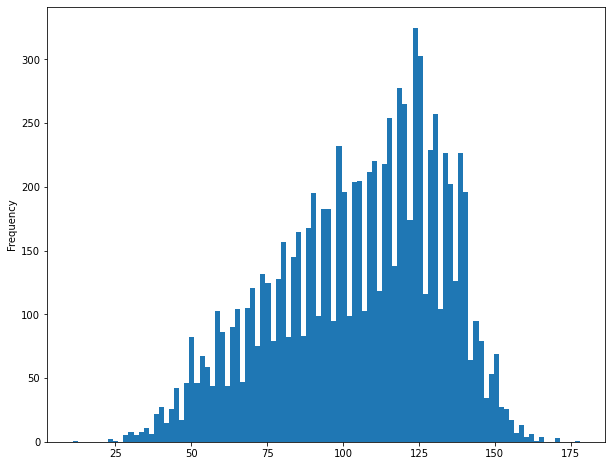

In [19]:
# plot the length of the tweet
df['length']= df['tweet']. apply(len)
df['length'].plot(bins=100, kind='hist',figsize=(10,8));
#the avarage length of the tweet between 90 to 110, min around 25, max around 175

In [20]:
# check shortest tweet 
df[df['length'] == 25]['tweet'].iloc[0]

'@mention #SXSW iPad rocks'

In [21]:
# check shortest tweet 
df[df['length'] == 25]['tweet'].iloc[0]

'@mention #SXSW iPad rocks'

In [22]:
# check longest tweet 
df[df['length'] == 170]['tweet'].iloc[0]

'RT @mention HUZZAH!  RT @mention &quot;Google before you tweet&quot; is the new &quot;think before you speak.&quot; - Mark Belinsky, #911tweets panel at #SXSW. #umassjour'

In [23]:
# check the avarage tweet
df[df['length'] == 110]['tweet'].iloc[0]

"GSD&amp;M &amp; Google's Industry Party Tonight @mention - See u there! {link} #SXSW #Austin #Welivehere #GSDM"

In [24]:
# Check how the data is distributed in sentiment columns
test1["sentiment"].value_counts()

no emotion toward brand or product    5372
positive emotion                      2968
negative emotion                       569
i can't tell                           156
Name: sentiment, dtype: int64

#### There are 4 classes: Positive, Negative, Neutral and I can't tell. A good way would be to combine both neutal and I'cant tell classes

In [25]:
# renaming the values within sentiment column
emotion = {"no emotion toward brand or product": "neutral",
            "positive emotion": "positive",
            "negative emotion": "negative",
            "i can't tell": "neutral"}

test1["sentiment"]=test1["sentiment"].map(emotion)

In [26]:
# create a new df to graph the sentiment distribution as a pie chart
df_pie=test1["sentiment"].value_counts().reset_index()
df_pie

,index,sentiment
0,neutral,5528
1,positive,2968
2,negative,569


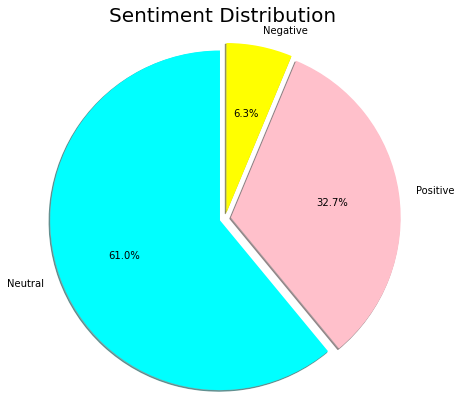

In [27]:
# Plot pie chart
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow"]
plt.pie(df_pie["sentiment"],labels=("Neutral","Positive","Negative"),radius=3,autopct="%1.1f%%",
        shadow = True,startangle = 90,labeldistance = 1.1,colors=colors,explode =(0.1,0.1,0.1))
plt.axis('equal')
plt.title("Sentiment Distribution ", fontsize=20)
#plt.savefig("images/Sentiment Distribution.png")
plt.show();

#### Out of 9065 sentiments:

 
 * 5528(61%) are Neutral sentiments
 * 2968(32.7%) are Positive sentiments
 * 569(6.3%) are Negative sentiments
 
 The data is imbalanced and skewed towards the neutral sentiment

#### Creating a new DataFrame To analyse products

In [28]:
# removing all null product values
df_prod=df[df["product"].notna()]

In [29]:
# sanity check
df_prod["product"].isna().sum()

0

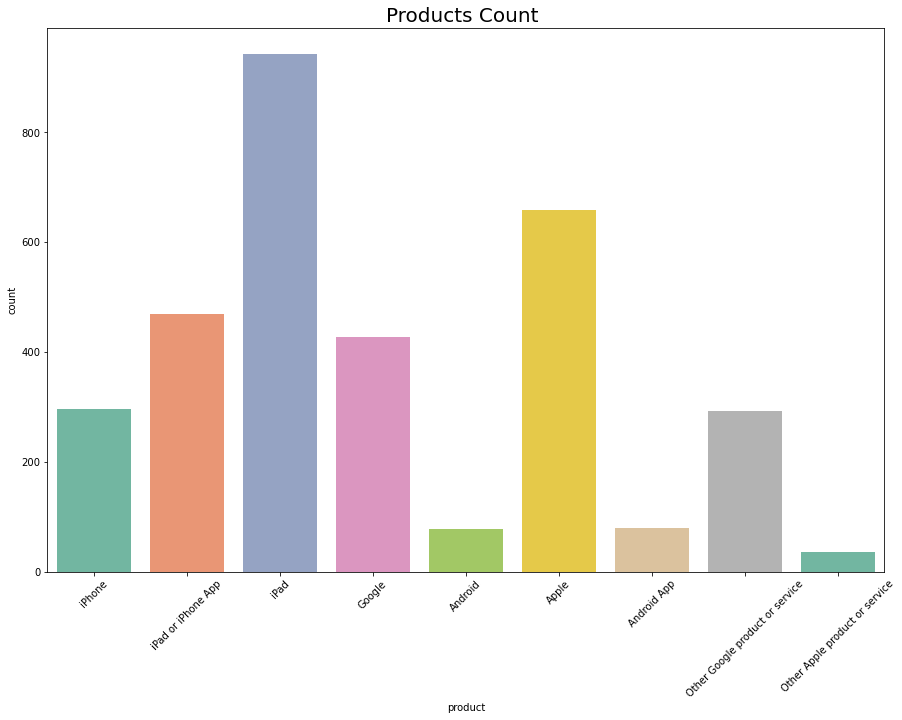

In [30]:
# plot product count
plt.subplots(figsize = (15,10))
chart=sns.countplot(x="product",data=df_prod, palette="Set2");
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Products Count ", fontsize=20)
#plt.savefig("images/Products Count.png")
plt.show();

#### There are 9 types of products which are mentioned in the dataset. Out of all the products:
  * Ipad is the most tweeted about, followed by apple(company)
  * Android, Android app and Other Apple products and services are less tweeted about.
  

#### Products vs Sentiments

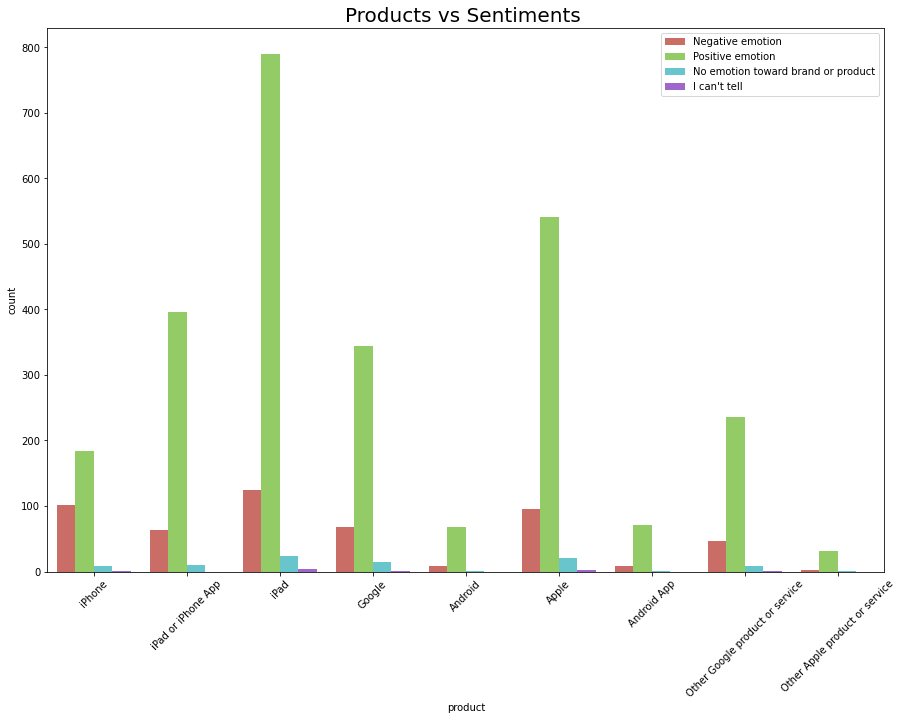

In [31]:
plt.subplots(figsize = (15,10))
chart=sns.countplot(x="product",hue="sentiment",data=df_prod,palette="hls")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Products vs Sentiments ", fontsize=20)
plt.savefig("images/Products Count.png",bbox_inches='tight')
plt.legend(loc= 'upper right')
plt.show();

#### Of all the sentiments per product:
 * All the products mostly have positive reviews associated with them.
 * Iphone has the highest proportions of negative sentiments of all products.
 * The neutral (no emotion,I can't tell) sentiment has a very small proportion in the entire data spread, which is contradictary to our original data. It means, that a lot of rows where product is null, the sentiment is neutral.
 

#### WordCloud

In [32]:
# create a function for word cloud
def create_wordcloud(text):
    words=' '.join([words for words in text])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

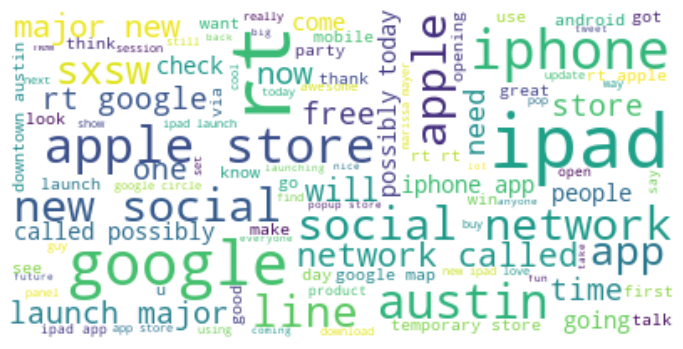

In [33]:
# wordcloud for all tweets
create_wordcloud(test1["tweet"].values)

#### The most common words across all tweets are:
 * Products such as Google, Iphone, Ipad, Apple
 * words such as Use, Today, Launch, Time,Network, Called etc.

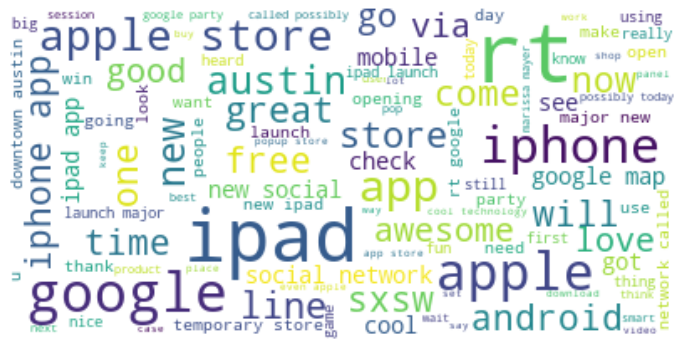

In [34]:
# wordcloud for all positive tweets
create_wordcloud(test1[test1["sentiment"]=="positive"]["tweet"].values)

#### The most common words across all Positive tweets are:
 * Products such as Google, Iphone, Ipad, Apple
 * words such as Nice, Great, Awesome, love, party, fun, good,smart, cool etc.

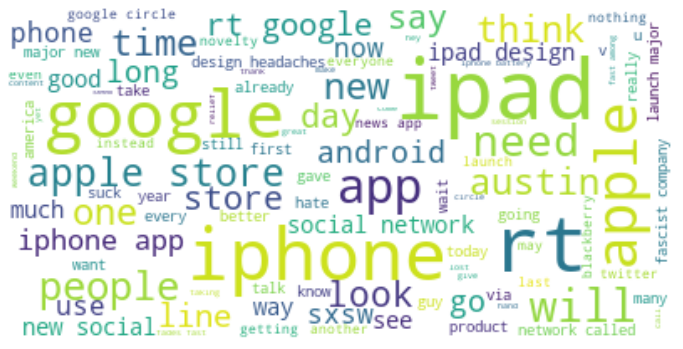

In [35]:
# wordcloud for all negative tweets
create_wordcloud(test1[test1["sentiment"]=="negative"]["tweet"].values)

#### The most common words across all Negative tweets are:
 * Products such as Google, Iphone, Ipad, Apple
 * words such as Long, suck, design headaches, wait, hate, battery, lost, fascist company, etc.

#### Hashtags Analysis

In [36]:
# Creating encoded column for sentiments by using .factorize() function in panda,which encode the object as an 
#enumerated type or categorical variable. # it works like label enoder but for features
df["sent_score"]=df["sentiment"].factorize()[0]
#for all tweets
tweets = df['tweet'].tolist()
len(tweets)

9065

## Hashtags

#### Most Frequent  hashtags in positive tweets

In [37]:
# extract positive hashtag
positive = df[df['sent_score']==1]
positive=positive.apply(lambda x:x.astype(str).str.lower())
positive_list = positive['tweet'].tolist() 
positive_sentences_to_string = ''.join(positive_list)
pos_hash = re.findall(r"#(\w+)",positive_sentences_to_string)
pos_freq = nltk.FreqDist(pos_hash)
pos_hash_df = pd.DataFrame({'hashtag': list(pos_freq.keys()),
                 'count': list(pos_freq.values())})
pos_hash_df=pos_hash_df.sort_values("count",ascending=False)[:10].head(10)
pos_hash_df

,hashtag,count
0,sxsw,2207
22,apple,160
9,sxswrt,159
17,ipad2,107
1,ipad,87
28,sxswi,84
36,iphone,80
55,google,66
4,android,40
12,austin,37


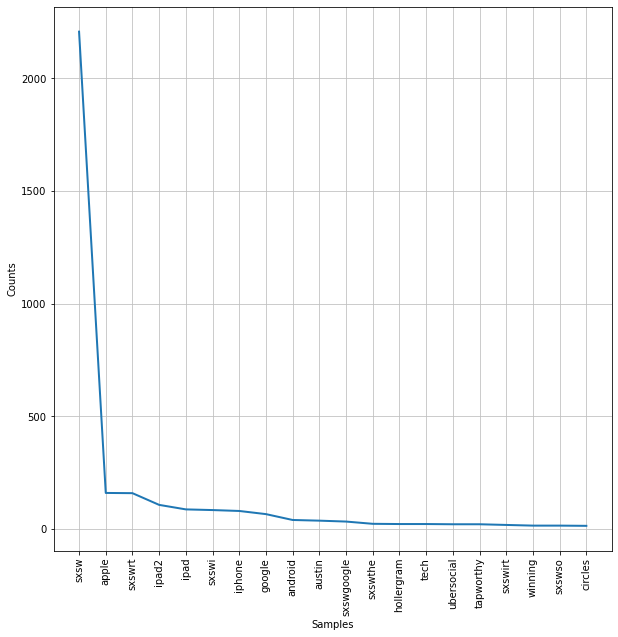

In [38]:
plt.figure(figsize=(10,10))
pos_freq.plot(20)
plt.show();

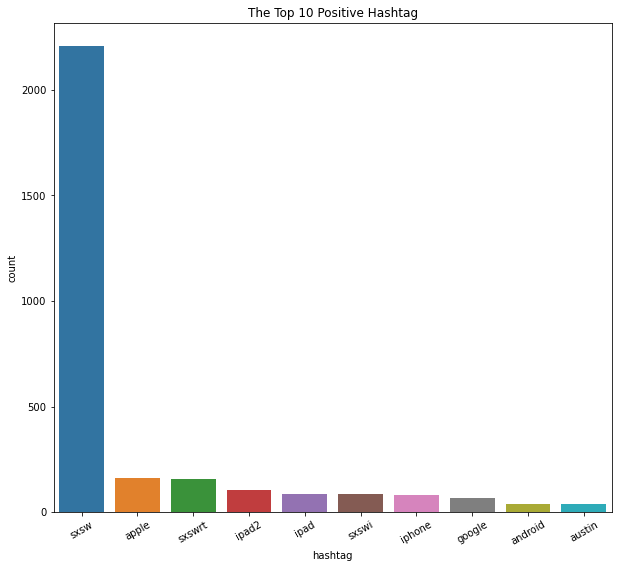

In [39]:
plt.subplots(figsize = (10,9))
plt.title("The Top 10 Positive Hashtag")
chart=sns.barplot(x="hashtag",y="count",data=pos_hash_df);
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
plt.savefig("images/The Top 10 Positive Hashtag.png",bbox_inches='tight');

#### Most frequent hashtags in Negative Tweets

In [40]:
#for all negative tweets
negative = df[df['sent_score']==0]
negative=negative.apply(lambda x:x.astype(str).str.lower())
negative_list = negative['tweet'].tolist() 
negative_sentences_to_string = ''.join(negative_list)
neg_hash = re.findall(r"#(\w+)",negative_sentences_to_string)
neg_freq = nltk.FreqDist(neg_hash)
neg_hash_df = pd.DataFrame({'hashtag': list(neg_freq.keys()),
                 'count': list(neg_freq.values())})
neg_hash_df=neg_hash_df.sort_values("count",ascending=False).head(10)
neg_hash_df

,hashtag,count
1,sxsw,351
219,sxswrt,51
32,ipad,18
2,sxswi,16
4,google,13
45,apple,12
3,iphone,12
70,tapworthy,11
68,fail,9
23,japan,9


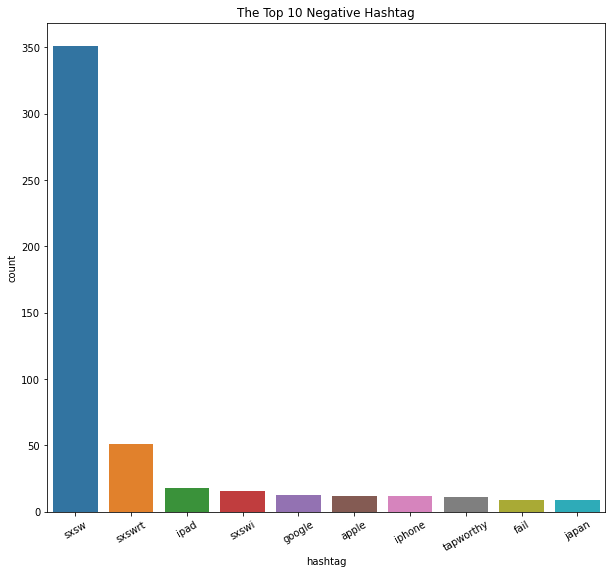

In [41]:
plt.subplots(figsize = (10,9))
plt.title("The Top 10 Negative Hashtag")
chart=sns.barplot(x="hashtag",y="count",data=neg_hash_df);
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
plt.savefig("images/The Top 10 Negative Hashtag.png",bbox_inches='tight');

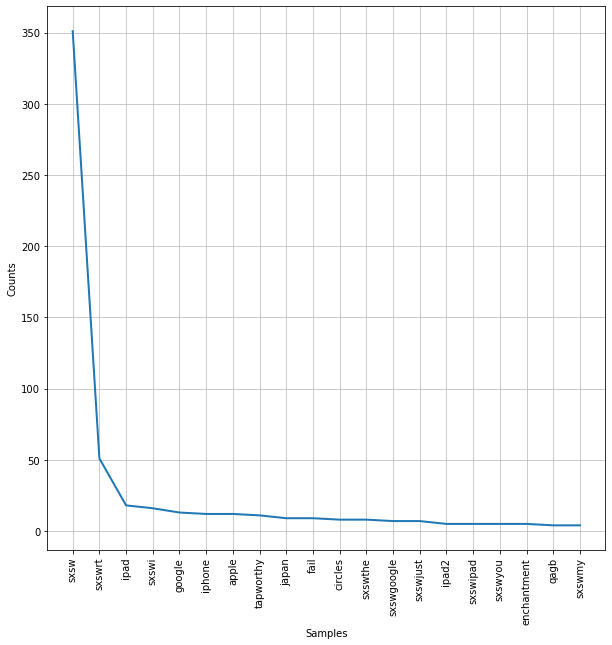

In [42]:
plt.figure(figsize=(10,10))
neg_freq.plot(20)
plt.show();

## Data PreProcessing

In [43]:
# Creating encoded column for sentiments by using .factorize() function in panda encode the object as an 
#enumerated type or categorical variable. 
test1["sent_score"]=test1["sentiment"].factorize()[0]

In [44]:
test1.head()

,tweet,product,sentiment,sent_score
0,i have a iphone after hrs tweeting at it was d...,iphone,negative,0
1,know about awesome app that likely appreciate ...,ipad or iphone app,positive,1
2,can not wait for also they should sale them do...,ipad,positive,1
3,i hope this festival as crashy as this iphone app,ipad or iphone app,negative,0
4,great stuff on fri marissa mayer tim matt mull...,google,positive,1


In [45]:
# check the count of the sent_score where 0=Negative, 1=Positive, 2=Neutral
test1["sent_score"].value_counts()

2    5528
1    2968
0     569
Name: sent_score, dtype: int64

In [46]:
# Dropping all neutral sentiments to generalize the model
test1=test1[test1["sentiment"]!="neutral"]

In [47]:
test1["sent_score"].value_counts(normalize=True)

1    0.839129
0    0.160871
Name: sent_score, dtype: float64

In [48]:
# create new df contains the sentiment and its encoded value, and create two dictionaries
sentiment_id_df =test1[['sentiment', 'sent_score']].drop_duplicates().sort_values('sent_score')
sentiment_to_id = dict(sentiment_id_df.values)
print("sentiment_to_id: ",sentiment_to_id)
id_to_sentiment = dict(sentiment_id_df[['sent_score', 'sentiment']].values)
print("id_to_sentiment: ",id_to_sentiment)

sentiment_to_id:  {'negative': 0, 'positive': 1}
id_to_sentiment:  {0: 'negative', 1: 'positive'}


In [49]:
#splitting the data to two(training and testing data)and validation data which I will keep aside for
#model validation later
df2, df_val = train_test_split(test1, test_size= 0.1, random_state=10)

In [50]:
# Define our X and y
X = df2['tweet']
y = df2['sent_score']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF/IDF Features

In [51]:
# Instantiate and fit TfidfVectorizer 
vectorizer = TfidfVectorizer(min_df=3,sublinear_tf=True,encoding="latin-1", ngram_range=(1,2),
                             stop_words='english')
#http://resources.mpi-inf.mpg.de/departments/d5/teaching/ws11_12/irdm/slides/irdm-3-2.pdf

In [52]:
X_train_tf= vectorizer.fit_transform(X_train.reset_index()["tweet"]).toarray()
X_test_tf = vectorizer.transform(X_test.reset_index()["tweet"]).toarray()

In [53]:
X_train_tf.shape
# There are 2546 rows having 1891 features

(2546, 1891)

### Metrics

#### F1 Score (F1)

$$\text{F1} = 2*\frac{\text{precision * recall}}{\text{precision + recall}} $$

$$\text{} = \frac{\text{TP}}{\text{TP+1/2(FP+FN)}} $$


F1 Score  is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric.F1-score is a better choice of metric when there are imbalanced classes as in our case. The F1 score minimize the False positives and False negatives.

#### Running the data over various models to check which is best suited model for our data

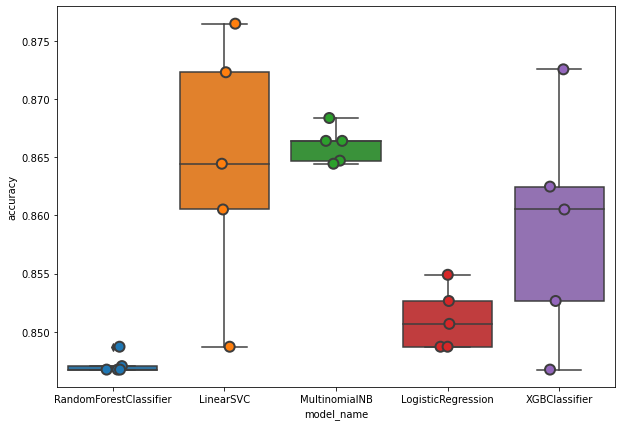

In [54]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    XGBClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.subplots(figsize = (10,7))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

#https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

In [55]:
# check the mean of the accuracy for each model
cv_df.groupby('model_name').accuracy.mean()
#From the above graph, it can be seen that the MultinomialNB  has the highest mean accuracy followed 
#by Linear SCV 

model_name
LinearSVC                 0.864489
LogisticRegression        0.851138
MultinomialNB             0.866065
RandomForestClassifier    0.847211
XGBClassifier             0.858989
Name: accuracy, dtype: float64

#### Hence, Implementing Linear SCV

In [56]:
# use evaluate function to evaluate our models
def evaluate(estimator, X_train, X_test, y_train, y_test, use_decision_function='yes'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    use_decision_function allows you to toggle whether you use decision_function or
    predict_proba in order to get the output needed for roc_auc_score
    If use_decision_function == 'skip', then it ignores calculating the roc_auc_score
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # output needed for roc_auc_score
    if use_decision_function == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif use_decision_function == 'yes': # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif use_decision_function == 'no':
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception ("The value for use_decision_function should be 'skip', 'yes' or 'no'.")

    print(type(test_out))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Recall: {recall_score(y_train, train_preds)}")
    print(f"Precision: {precision_score(y_train, train_preds)}")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    if type(train_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Recall: {recall_score(y_test, test_preds)}")
    print(f"Precision: {precision_score(y_test, test_preds)}")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test)
    plt.show()

#### Linear SVC (Support Vector Classifier)

In [57]:
svc = LinearSVC()
svc.fit(X_train_tf, y_train)
y_pred = svc.predict(X_test_tf)

<class 'numpy.ndarray'>
Train Scores
------------
Recall: 0.9949003245248029
Precision: 0.9627635711081203
Accuracy: 0.9630793401413983
F1 Score: 0.9785681714546285
ROC-AUC: 0.9905318130842012
--------------------
Test Scores
-----------
Recall: 0.9613152804642167
Precision: 0.8673647469458988
Accuracy: 0.8492935635792779
F1 Score: 0.9119266055045873
ROC-AUC: 0.7927224371373307


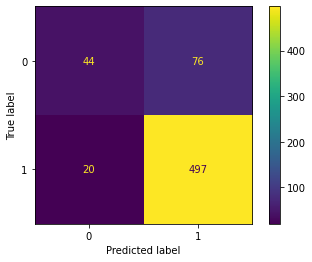

In [58]:
# Evaluate
evaluate(svc, X_train_tf, X_test_tf, y_train, y_test,use_decision_function='yes')

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.37      0.48       120
           1       0.87      0.96      0.91       517

    accuracy                           0.85       637
   macro avg       0.78      0.66      0.70       637
weighted avg       0.83      0.85      0.83       637



#### Multinomial Naive Bayes

In [60]:
nb = MultinomialNB()
nb.fit(X_train_tf, y_train)
y_pred_nb = nb.predict(X_test_tf)

<class 'bool'>
Train Scores
------------
Recall: 0.9986091794158554
Precision: 0.8752539618041446
Accuracy: 0.8782403770620582
F1 Score: 0.9328713728886964
--------------------
Test Scores
-----------
Recall: 1.0
Precision: 0.8258785942492013
Accuracy: 0.8288854003139717
F1 Score: 0.9046369203849519


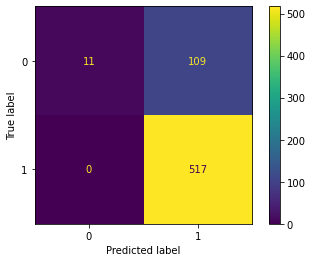

In [61]:
# Evaluate
evaluate(nb, X_train_tf, X_test_tf, y_train, y_test,use_decision_function='skip')

In [62]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       1.00      0.09      0.17       120
           1       0.83      1.00      0.90       517

    accuracy                           0.83       637
   macro avg       0.91      0.55      0.54       637
weighted avg       0.86      0.83      0.77       637



#### XGBoost

In [63]:
xgb = XGBClassifier()
xgb.fit(X_train_tf, y_train)
y_pred_xgb = xgb.predict(X_test_tf)

<class 'bool'>
Train Scores
------------
Recall: 0.9972183588317107
Precision: 0.9137638062871708
Accuracy: 0.917910447761194
F1 Score: 0.9536688095765906
--------------------
Test Scores
-----------
Recall: 0.9690522243713733
Precision: 0.8448566610455311
Accuracy: 0.8304552590266876
F1 Score: 0.9027027027027028


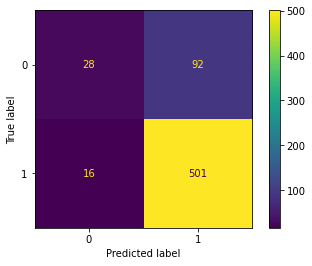

In [64]:
evaluate(xgb, X_train_tf, X_test_tf, y_train, y_test,use_decision_function='skip')

In [65]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.64      0.23      0.34       120
           1       0.84      0.97      0.90       517

    accuracy                           0.83       637
   macro avg       0.74      0.60      0.62       637
weighted avg       0.81      0.83      0.80       637



### Multinomial Naive Bayes VS Linear SVC

* The mean accuracy of Linear SVC is  86.4%
* The mean accuracy of Multinomial Naive Bayes is  86.6%
* Although the accuracy of Multinomial Naive Bayes is more, when we plot the confusion matrix,and classification report we can see that Linear SVC has a better F1 score than Multinomial Naive Bayes for Negative Tweets
* As a result, it can identify the Negative tweets more accurately than Multinomial Naive Bayes
* Hence, We choose, Linear SVC as our final model

#### Testing the data

In [66]:
df.head()

,tweet,product,sentiment,length,sent_score
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,1


In [67]:
df['tweet'][16]

'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone'

In [68]:
# test the data
tweet ='I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone'
clean=vectorizer.transform([tweet]) #apply TFIDF
pred=svc.predict(clean) # predict the tweet using out model
pred=id_to_sentiment[pred[0]]
print(pred)

negative


## Feature Importance

In [69]:
# Referred the below link to plot Most important features(words) within the model
#https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d#:~:text=Once%20a%20linear%20SVM%20is,can%20be%20accessed%20with%20svm.&text=The%20absolute%20size%20of%20the,for%20the%20data%20separation%20task.

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

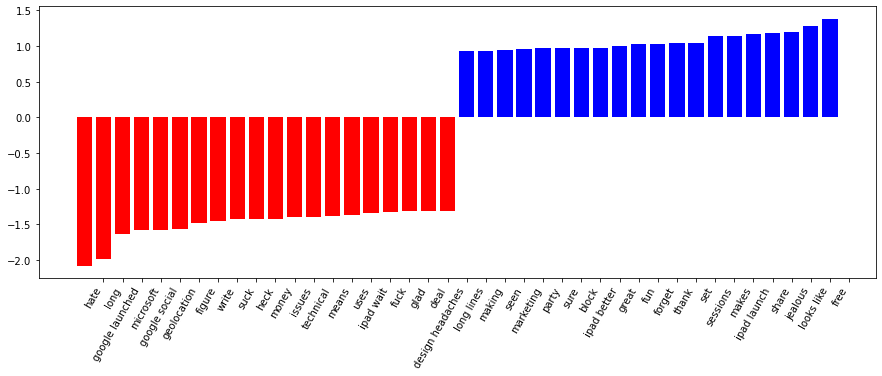

In [70]:
feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(svc.coef_[0], feature_names))
df_feat=pd.DataFrame(coefs_with_fns)
df_feat.columns='coefficient','word'
df_feat.sort_values(by='coefficient')
plot_coefficients(svc, feature_names)
#plt.savefig("images/.png")

#### The plot provides useful insight into what features (words) are being used by the model to make the positive and negative classifications from a sentiment dataset

### Validate the model

In [71]:
#validate the model
df_val= df_val.reset_index()
df_val.tail()

,index,tweet,product,sentiment,sent_score
349,75,i love my iphone case from but i get my phone ...,iphone,positive,1
350,3832,iphones etc on and wifi frozen at but teatheri...,android,positive,1
351,3529,just bought one of the last few ipads at the a...,ipad,positive,1
352,3861,ipad is now available for online ordering go g...,ipad,positive,1
353,5252,rt omitting flash on apple seems even though t...,apple,positive,1


In [72]:
df_val['tweet'][350]

'iphones etc on and wifi frozen at but teathering on my android works like a charm'

In [73]:
# Define our X and y
X_val = df_val['tweet']
y_val = df_val['sent_score']

In [74]:
# vectorize the model
vectorizer = TfidfVectorizer(min_df=3,sublinear_tf=True,encoding="latin-1", ngram_range=(1,2),
                             stop_words='english')

In [75]:
X_val_tf= vectorizer.fit_transform(X_val.reset_index()["tweet"]).toarray()

In [76]:
svc.fit(X_val_tf, y_val)

LinearSVC()

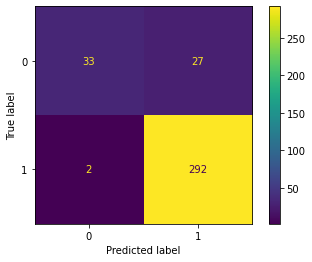

In [77]:
plot_confusion_matrix(svc,X_val_tf,y_val)

In [78]:
print(f"Recall: {recall_score(y_val, svc.predict(X_val_tf))}")
print(f"Precision: {precision_score(y_val, svc.predict(X_val_tf))}")
print(f"Accuracy: {accuracy_score(y_val, svc.predict(X_val_tf))}")
print(f"F1 Score: {f1_score(y_val, svc.predict(X_val_tf))}")

Recall: 0.9931972789115646
Precision: 0.9153605015673981
Accuracy: 0.9180790960451978
F1 Score: 0.9526916802610114


### Conclusions

### After exploring multiple classifying models through cross validation technique and vectorizing withTfdif, I found out:

 * Visualized the dataset and observed that there were more neutral sentiments as compared to positive and negative sentiments.
 * However,vafter dropping all the products which had null values, observed that the neutral sentiment has a very small proportion in the entire data spread, which is contradictory to our original data. It means, that in a lot of rows where the product is null, the sentiment is neutral.
 * All the models perform better with Tfdif vectorizer. Tfdif gives us most frequently present n-grams(words) within our dataset that helps our model to understand the data more efficiently and map correlations.
 * The best performing model of the whole lot was LinearSVC. It gave us an accuracy of 84.9% with F1 score of 91%
 * LinearSCV which works on the concept of hyperplanes helps us distinguish between positive and negative sentiments with a decent accuracy
 * Also, the most important features(words) in negative tweets were : hate, long, suck, heck, money,issue etc.
 * The most important features(words) in positive tweets were : party, ipad better, free, ipad launch, thanks, great etc.

### Limitation
 More data is needed to better categorize the sentiment, especially in the negative sentiment category.

### Future work
 * Add Neutral sentiments to the target variables along with Positive and Negative. 
 * Strategies need to be implemented to balance the data.
 * Use of Embeddings.CBoW, Glove, or Bert embeddings can be used to cluster similar meaning words together. This will help to distinguish words between positive, negative and neutral sentiments thoroughly.
 * Use pre-trained models such as Transformer-5(T5) and check how they perform over the dataset.
 